In [ ]:
import os
import json
import importlib

import glob as gb
import utils as ut
import numpy as np
import pandas as pd
import seaborn as sns
import ipywidgets as pyw
import matplotlib.pyplot as plt
import matplotlib.image as Image

from tqdm import tqdm
from IPython.display import HTML, display, clear_output

In [ ]:
importlib.reload(ut);

In [ ]:
%matplotlib inline

# Global

In [ ]:
dark_mode = False

In [ ]:
plt.rcParams['text.usetex'] = True
plt.style.use(['dark_background' if dark_mode else 'default'])

In [ ]:
pd.set_option('display.max_colwidth', None)

# Data

## Load

In [ ]:
# init
data = {}
df = pd.DataFrame()
path = os.path.join('data', 'output', 'v10*', '**', 'data*.npz')

# load pre-processed data
for path_data in tqdm(sorted(gb.glob(path, recursive=True))):
    
    # file directory and file name
    file_directory = os.path.dirname(path_data)
    file_name, _ = os.path.splitext(os.path.basename(path_data))
    
    # filter by file name
    file_filter = []
    if any([x for x in file_filter if x in path_data]):
         continue
    
    # load simulation parameters
    parameters_json = next(iter(gb.glob(os.path.join(file_directory, 'parameters*.json'))), None)
    if not parameters_json:
        continue
    parameters = json.load(open(parameters_json))
    ut.del_keys(parameters, 'forest.persons')
    ut.del_keys(parameters, 'material')
    ut.del_keys(parameters, 'capture')
    ut.del_keys(parameters, 'next')
    ut.del_keys(parameters, 'url')
    
    # get parameter values
    preset = ut.get_value(parameters, 'preset')
    size = ut.get_value(parameters, 'forest.size')
    height = ut.get_value(parameters, 'drone.height')
    coverage = ut.get_value(parameters, 'drone.coverage')
    view = ut.get_value(parameters, 'drone.camera.view')
    sampling = ut.get_value(parameters, 'drone.camera.sampling')
    
    # TEMPORARY
    if view >= 100:
        continue
        
    # hardcoded number/distance of captures by file name
    N, M = ut.sample_data(parameters)
    n = int(file_name.split('-')[-1][1:])
    m = M[n]
    
    # hardcoded perspective/orthographic camera by file name
    c = 'O' if 'orthographic' in file_directory else 'P'
    
    # simulation name, group and ground image
    simulation = os.path.basename(file_directory)
    subgroup = os.path.basename(os.path.dirname(file_directory))
    group = os.path.basename(os.path.dirname(os.path.dirname(file_directory)))
    name = f'{preset}-F{size:04}-N{n:03}-H{height}-V{view}-S{sampling:.1f}-{c}'
    image = gb.glob(os.path.join(file_directory, f'ground-*-N{n:03d}.png'))[0]
    
    # load alphas, ground and statistics
    data[simulation] = np.load(path_data, allow_pickle=True)   
    # alphas = data[simulation]['alphas']
    # ground = data[simulation]['ground']
    statistics = data[simulation]['statistics'].item()
    
    # statistics data
    trees = statistics['trees_per_image']
    visibility = statistics['ground_visibility']
    density = 1.0 - visibility
    
    # TODO check scanned = np.count_nonzero(ground[:, :, 0]) vs scanned = np.sum(ground[:, :, 0])
    
    # append simulation data
    df = df.append(pd.json_normalize({
        'name': name,
        'group': group,
        'subgroup': subgroup,
        'simulation': simulation,
        'visibility': visibility,
        'density': density,
        'trees': trees,
        'image': image,
        'C': c,
        'N': n,
        'M': m,
        **parameters
    }), ignore_index=True)

## Preview

In [ ]:
# sort and preview data
df = df.sort_values(['group', 'subgroup', 'drone.camera.view'], ascending=True)
df = df.reset_index(drop=True)
df = df.fillna(0.0)
df

In [ ]:
# extract unique subgroups
subgroups = sorted(df['subgroup'].unique(), key=lambda x: x[10:])
subgroups

In [ ]:
%%script false --no-raise-error #####################
################## DISABLE CELL #####################

# sort
df = df.sort_values(['preset', 'drone.camera.view', 'N'], ascending=True)

# mask
mask = (df['N'] >= np.floor(df['drone.coverage'])) & (df['N'] <= np.ceil(df['drone.coverage'])) & (df['C'] == 'P')

# density increasement factor by resolution decreasement (higher FOV)
df_resolution = df[mask][['preset', 'drone.camera.view', 'density']].copy()
for preset, group in df_resolution.groupby('preset')[['density']].min().iterrows():
    for index, row in df_resolution[df_resolution['preset'] == preset].iterrows():
        df_resolution.loc[index, 'denseness'] = group['density']
        df_resolution.loc[index, 'delta'] = row['density'] - group['density']

# append resolution density corrected rows
df_copy = df.copy()
for index, row in df_resolution.iterrows():
    mask = (df_copy['preset'] == row['preset']) & (df_copy['drone.camera.view'] == row['drone.camera.view'])
    df_copy.loc[mask, 'density'] -= row['delta']
    df_copy.loc[mask, 'visibility'] += row['delta']
    df_copy.loc[mask, 'denseness'] = row['denseness']
df_copy['preset'] += '-resolution'

# merge datasets
df = df_copy.append(df, ignore_index=True)

df.filter(regex=r'^(?:(?!data).)*$')

# Plots

## Models

In [ ]:
def D_tilde(D, lo):
    """
    Density model
    
    :param D: density per slice
    :param lo: height/occluder ratio
    
    :return: density
    """
    return 1 - (1 - D)**lo

def D_tilde_alpha_slice(D, lo, a):
    """
    Density model considering obligue angle
    
    :param D: density per slice
    :param lo: height/occluder ratio
    :param a: obligue angle
    
    :return: density
    """
    return 1 - (1 - D_tilde(D, lo))**(lo * 1 / np.cos(np.deg2rad(a)))

def D_tilde_alpha(D, a):
    """
    Density model considering obligue angle
    
    :param D: density per image
    :param a: obligue angle
    
    :return: density
    """
    return 1 - (1 - D)**(1 / np.cos(np.deg2rad(a)))

def D_atmos(D, h, H):
    """
    TODO
    """
    return D * np.exp(-h / H)

In [ ]:
def V1(D, N, d=1):
    """
    TODO
    """
    S = 0
    k = np.floor(N).astype(np.int16)
    for i in range(1, k + 1):
        S += (np.sqrt(N) - i) * np.maximum(0, (1 - i * d))
    return 1 - D**2 - D * (1 - D) / N**2 * (N + 2 * S)

def V2(D, N, d=1):
    """
    TODO
    """
    S = 0
    k = np.floor(np.sqrt(N) - 1).astype(np.int16)
    for i in range(1, k + 1):
        for j in range(0, k + 1):
            S += (np.sqrt(N) - i) * (np.sqrt(N) - j) * np.maximum(0, (1 - i * d)) * np.maximum(0, (1 - j * d))
    return 1 - D**2 - D * (1 - D) / N**2 * (N + 4 * S)

def V(D, N, d=1, dim=2):
    """
    TODO
    """
    return V1(D, N, d) if dim == 1 else V2(D, N, d)

def V_opt(D, N):
    """
    TODO
    """
    return 1 - D**2 - D * (1 - D) / N

def V_hat(N):
    """
    TODO
    """
    return 1 - 1 / N

V = np.vectorize(V)

## Visibility

In [ ]:
def plot_visibility_hat_model(N, ax):
    _N = np.arange(N[0], N[1] + 1)
    V_V_hat_vs_N = np.vstack([_N, V_hat(_N)]).T
    
    # plot
    columns = [r'number of images $N$'] + [r'visibility $\hat{V}$']
    df = pd.DataFrame(V_V_hat_vs_N, columns=columns).set_index(r'number of images $N$')
    df.plot(kind='line', linestyle='solid', color='red', ax=ax)

In [ ]:
def plot_visibility_model(D, N, FOV, d, h, H, title, color, ax):    
    _N = np.arange(N[0], N[1] + 1)
    _D = np.array([D_tilde_alpha(D, FOV / 2)] * (N[1] - N[0] + 1))
    # _D = np.array([D_atmos(D, h, H)] * (N[1] - N[0] + 1))
    # V_V_vs_N = np.vstack([_N, V(_D, _N, d)]).T
    V_V_vs_N = np.vstack([_N, V_opt(_D, _N)]).T
    
    # plot
    columns = [r'number of images $N$'] + [title]
    df = pd.DataFrame(V_V_vs_N, columns=columns).set_index(r'number of images $N$')
    df.plot(kind='line', linestyle='solid', color=color, ax=ax)

In [43]:
def plot_visibilities(df, mask, group, title, label, **kwargs):
    
    # group dataframe
    group_name_0, group_name_1 = group
    grouped_0 = df[mask].groupby(group_name_0, sort=False)
    
    # aggregate data
    for i, (name_0, group_0) in enumerate(grouped_0):
        
        # initialize subplots
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # initialize colors
        grouped_1 = group_0.groupby(group_name_1, sort=False)
        colors = ut.colors(cmap='tab10', size=len(grouped_1))
        
        # plot visibility normalized
        # plot_visibility_hat_model(N=kwargs['N'], ax=ax)
        
        # plot visibilities
        for j, (name_1, group_1) in enumerate(grouped_1):
            
            N = group_1['N'].iloc[j]
            view = group_1['drone.camera.view'].iloc[j]
            coverage = group_1['drone.coverage'].iloc[j]
            color = colors[j]
            
            # 0.6 meter sampling point
            sampling_0_6m = group_1[(group_1['M'] == 0.6)]
            # ax.scatter(sampling_0_6m['N'], sampling_0_6m['visibility'], marker='x', color=color)
            
            # 1.0 meter sampling point
            sampling_1_0m = group_1[(group_1['M'] == 1.0)]
            ax.scatter(sampling_1_0m['N'], sampling_1_0m['visibility'], marker='.', color=color)
            
            # 1.6 meter sampling point
            sampling_1_6m = group_1[(group_1['M'] == 1.6)]
            # ax.scatter(sampling_1_6m['N'], sampling_1_6m['visibility'], marker='o', color=color)
             
            # simulation visibilities
            group_1.plot(kind='line', x='N', y='visibility', linestyle='solid', label=label % name_1, color=color, ax=ax)
            
            # model visibilities
            #D = 1 - group_1['visibility'][group_1['N'] == 1].item() # using N=1 for current FoV (perspective projection)
            #D = 1 - group_0['visibility'][group_0['N'] == 1].mean() # using N=1 mean over all FoV (perspective projection)
            #D = 1 - group_1['denseness'][group_1['N'] == 1].item() # real density obtained by ortographic projection
            #plot_visibility_model(D=D, N=kwargs['N'], FOV=view, d=1, h=0, H=0, title=label % name_1, color=color, ax=ax)
            
            # plot title
            ax.set_title(title % name_0)
        
        # set axis
        ax.set_xlim(np.add(kwargs['N'], [0, 20]))
        ax.set_ylim([0, 1.1])
        
        # set labels
        ax.set_xlabel(r'number of images $N$')
        ax.set_ylabel(r'visibility $\dot{V}$')
        
        # set legend
        #ax.legend(loc='lower right')
        ax.legend()

### Views

In [44]:
# sort
df = df.sort_values(['name'], ascending=True)

# group value
value = [
    'forest-21-sampling-0.1', 'forest-22-sampling-0.1', 'forest-23-sampling-0.1',
    'forest-21-cone-sampling-0.1', 'forest-22-cone-sampling-0.1', 'forest-23-cone-sampling-0.1'
]
value = []

@pyw.interact
def plot(G=pyw.SelectMultiple(value=value, options=subgroups, continuous_update=False),
         N=pyw.IntRangeSlider(value=(1, 200), min=1, max=500, continuous_update=False)):
    
    # mask
    mask = df['subgroup'].isin(G)
    
    # group
    df['plotgroup.0'] = df['subgroup']
    df['plotgroup.1'] = df['drone.camera.view'].astype('str') #+ '° (' + np.round(df['drone.coverage'], 1).astype('str') + 'm coverage)'
    
    # plot
    plot_visibilities(df, mask, ['plotgroup.0', 'plotgroup.1'], '%s', 'field of view %s', N=N)

interactive(children=(SelectMultiple(description='G', options=('forest-21', 'forest-22', 'forest-23', 'forest-…

### Forests

In [45]:
# sort
df = df.sort_values(['name'], ascending=True)

# group value
value = [
    'forest-21-sampling-0.1', 'forest-22-sampling-0.1', 'forest-23-sampling-0.1',
    'forest-21-cone-sampling-0.1', 'forest-22-cone-sampling-0.1', 'forest-23-cone-sampling-0.1'
]
value = []

@pyw.interact
def plot(G=pyw.SelectMultiple(value=value, options=subgroups, continuous_update=False),
         N=pyw.IntRangeSlider(value=(1, 80), min=1, max=400, continuous_update=False)):
    
    # mask
    mask = df['subgroup'].isin(G)
    
    # group
    df['plotgroup.0'] = df['drone.camera.view'].astype('str') + '° (' + np.round(df['drone.coverage'], 1).astype('str') + 'm coverage)'
    df['plotgroup.1'] = df['subgroup']
    
    # plot
    plot_visibilities(df, mask, ['plotgroup.0', 'plotgroup.1'], 'field of view %s', '%s', N=N)

interactive(children=(SelectMultiple(description='G', options=('forest-21', 'forest-22', 'forest-23', 'forest-…

### Heights

In [ ]:
%%script false --no-raise-error #####################
################## DISABLE CELL #####################

# sort
df = df.sort_values(['name'], ascending=True)

# group value
value = [
    'forest-21-height-30', 'forest-21-height-40', 'forest-21-height-50', 'forest-21-height-60',
    'forest-22-height-30', 'forest-22-height-40', 'forest-22-height-50', 'forest-22-height-60',
    'forest-23-height-30', 'forest-23-height-40', 'forest-23-height-50', 'forest-23-height-60'
]

@pyw.interact
def plot(G=pyw.SelectMultiple(value=value, options=subgroups, continuous_update=False),
         N=pyw.IntRangeSlider(value=(1, 100), min=1, max=400, continuous_update=False),
         FOV=pyw.IntSlider(value=50, min=20, max=90, step=10, continuous_update=True)):
    
    # mask
    mask = df['subgroup'].isin(G) & (df['drone.camera.view'] == FOV)
    
    # group
    df['plotgroup.0'] = df['preset'] + '-view-' + df['drone.camera.view'].astype('str')
    df['plotgroup.1'] = df['preset'] + '-height-' + df['drone.height'].astype('str') + 'm (' + np.round(df['drone.coverage'], 1).astype('str') + 'm coverage)'
    
    # plot
    plot_visibilities(df, mask, ['plotgroup.0', 'plotgroup.1'], '%s°', '%s', N=N)

## Density

$\tilde{D}_{\rho}$ ... perspective density if $N=1$

$\tilde{D}_{o}$ ... ortographic density if $N=1$ (in the model $D = \tilde{D}_{o}$)

In [ ]:
def plot_densities(df, mask, group, title):
    
    # group dataframe
    group_name_0 = group
    grouped_0 = df[mask].groupby(group_name_0)
    
    # initialize subplots
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # initialize colors
    forests = len(df[mask]['preset'].unique())
    #types = len(df[mask]['drone.height'].unique())
    types = len(np.unique([x[10:] for x in df[mask]['subgroup'].unique()]))
    colors = ut.colors(cmap='tab10', size=forests)
    
    # plot density
    linestyles = ['solid', 'dashed', 'dashdot', 'dotted', '-', '--', '-.', ':', ' ', '']
    for i, (name_0, group_0) in enumerate(grouped_0):
        j, k = i % types, i // types
        group_0.plot(kind='line', x='drone.camera.view', y='density', linestyle=linestyles[j], label=name_0, color=colors[k], ax=ax)
    
    # set axis
    ax.set_xlim(np.add([20, 90], [0, 20]))
    ax.set_ylim([0, 1.1])
    
    # set labels
    ax.set_xlabel(r'field of view°')
    ax.set_ylabel(r'density $\dot{D}$')
    
    # sort legend
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda x: x[0], reverse=True))
    ax.legend(handles, labels, loc='upper right')
    
    # plot title
    fig.suptitle(title)

### Distances

interactive(children=(SelectMultiple(description='G', options=('forest-21', 'forest-22', 'forest-23', 'forest-…

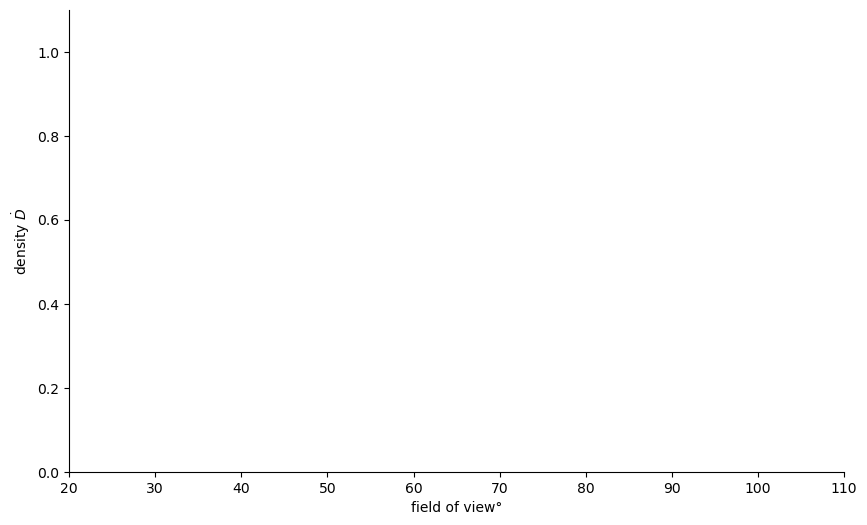

In [47]:
# sort
df = df.sort_values(['name'], ascending=True)

# group value
value = [
    'forest-21-sampling-0.1', 'forest-22-sampling-0.1', 'forest-23-sampling-0.1',
    'forest-21-cone-sampling-0.1', 'forest-22-cone-sampling-0.1', 'forest-23-cone-sampling-0.1'
]
value = []

@pyw.interact
def plot(G=pyw.SelectMultiple(value=value, options=subgroups, continuous_update=False),
         M=pyw.FloatSlider(value=1.0, min=0.1, max=10.0, step=0.1, continuous_update=True)):
    
    # mask
    mask = df['subgroup'].isin(G)
    
    ###################### <TODO> ######################
    views = df[mask]['drone.camera.view'].unique()
    steps = np.round(np.arange(0.0, 10.0, 0.1), 2)
    views = {x:{y:[] for y in views} for x in df[mask]['subgroup'].unique()}
    
    for subgroup in df[mask]['subgroup'].unique():
        for step in steps:
            subgroup_mask = mask & (df['subgroup'] == subgroup) & (df['M'] == M + step)
            for idx, view in df[subgroup_mask]['drone.camera.view'].items():
                views[subgroup][view].append(idx)
    idxs = np.array([[y[0] for y in x.values()] for x in views.values()]).flatten()
    
    #mask = df.index.isin(idxs)
    mask = df['subgroup'].isin(G) & (df['M'] == M)
    ###################### </TODO> ######################
    
    # group
    df['plotgroup.0'] = df['subgroup']# + ' (M=' + df['M'].astype('str') + ')'
    
    # plot
    plot_densities(df, mask, 'plotgroup.0', f'density by distance')

### Captures

interactive(children=(SelectMultiple(description='G', options=('forest-21', 'forest-22', 'forest-23', 'forest-…

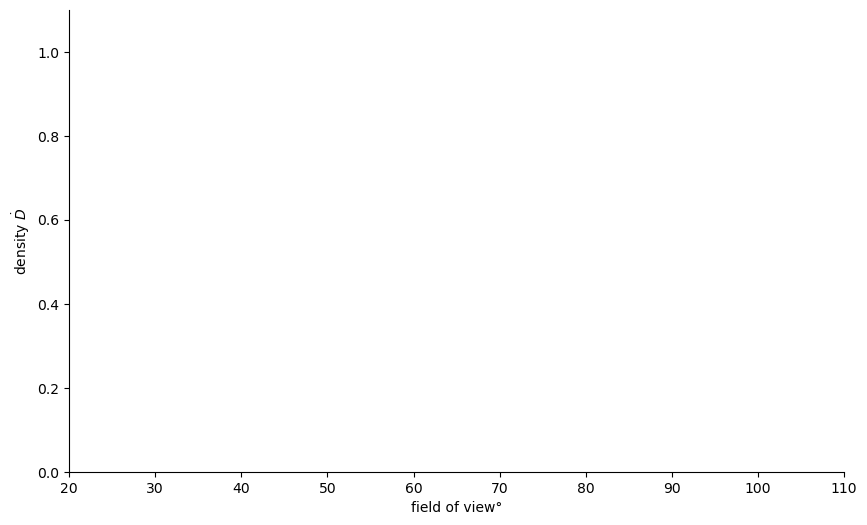

In [46]:
# sort
df = df.sort_values(['name'], ascending=True)

# group value
value = [
    'forest-21-sampling-0.1', 'forest-22-sampling-0.1', 'forest-23-sampling-0.1',
    'forest-21-cone-sampling-0.1', 'forest-22-cone-sampling-0.1', 'forest-23-cone-sampling-0.1'
]
value = []

@pyw.interact
def plot(G=pyw.SelectMultiple(value=value, options=subgroups, continuous_update=False),
         N=pyw.IntSlider(value=1, min=1, max=20, step=1, continuous_update=True)):
    
    # mask
    mask = df['subgroup'].isin(G)
    
    ###################### <TODO> ######################
    views = df[mask]['drone.camera.view'].unique()
    steps = np.arange(1, 10, 1)
    views = {x:{y:[] for y in views} for x in df[mask]['subgroup'].unique()}
    
    for subgroup in df[mask]['subgroup'].unique():
        for step in steps:
            subgroup_mask = mask & (df['subgroup'] == subgroup) & (df['N'] == N + step)
            for idx, view in df[subgroup_mask]['drone.camera.view'].items():
                views[subgroup][view].append(idx)
    idxs = np.array([[y[0] for y in x.values()] for x in views.values()]).flatten()
    
    #mask = df.index.isin(idxs)
    mask = df['subgroup'].isin(G) & (df['N'] == N)
    ###################### </TODO> ######################
    
    # group
    df['plotgroup.0'] = df['subgroup']# + ' (N=' + df['N'].astype('str') + ')'
    
    # plot
    plot_densities(df, mask, 'plotgroup.0', f'density by captures')

## Trees

In [ ]:
def plot_trees(df, mask, group, title):
    
    # group dataframe
    group_name_0 = group
    grouped_0 = df[mask].groupby(group_name_0)
    
    # initialize subplots
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # initialize colors
    forests = len(df[mask]['preset'].unique())
    types = len(np.unique([x[10:] for x in df[mask]['subgroup'].unique()]))
    colors = ut.colors(cmap='tab10', size=forests)
    
    # plot density
    linestyles = ['solid', 'dashed', 'dashdot', 'dotted', '-', '--', '-.', ':', ' ', '']
    for i, (name_0, group_0) in enumerate(grouped_0):
        j, k = i % types, i // types
        group_0.plot(kind='line', x='trees', y='visibility', linestyle=linestyles[j], label=name_0, color=colors[k], ax=ax)
    
    # set axis
    #ax.set_xlim(np.add([20, 90], [0, 20]))
    ax.set_ylim([0, 1.1])
    
    # set labels
    ax.set_xlabel(r'trees per image')
    ax.set_ylabel(r'visibility $\dot{V}$')
    
    # set legend
    ax.legend()
    
    # plot title
    fig.suptitle(title)

### Forests

In [ ]:
# sort
df = df.sort_values(['name'], ascending=True)

# group value
value = [
    'forest-100'
]
value = []

@pyw.interact
def plot(G=pyw.SelectMultiple(value=value, options=subgroups, continuous_update=False),
         N=pyw.IntSlider(value=1, min=1, max=20, step=1, continuous_update=True)):
    
    # mask
    mask = df['subgroup'].isin(G) & (df['N'] == N)
    
    # group
    df['plotgroup.0'] = df['subgroup']
    
    # plot
    plot_trees(df, mask, 'plotgroup.0', f'number of trees')

## Grounds

In [ ]:
def plot_grounds(df, data, mask, group, title, subtitle):
    
    # group dataframe
    group_name_0, group_name_1 = group
    grouped_0 = df[mask].groupby(group_name_0)
    
    # aggregate data
    for i, (name_0, group_0) in enumerate(grouped_0):
        
        # subplots layout
        n_cols = 3
        n_rows = len(group_0)
        
        # initialize subplots
        fig, axs = plt.subplots(n_rows, n_cols, figsize=(24, n_rows * 7))
        fig.tight_layout(pad=5.0, h_pad=5.0, w_pad=2.0)
        
        for j, simulation in enumerate(group_0['simulation']):
            name_1 = subtitle % group_0[group_name_1].iloc[j]
            print(f'load {title % name_0}', end='')
            
            # load ground
            ground = data[simulation]['ground']
            visibility = group_0['visibility'].iloc[j]
            
            # plot ground images
            ax = axs[j] if n_rows > 1 else axs
            ut.plot_heatmap(ax[0], ground[:, :, 0], f'{name_1} - scanned pixels (count)')
            ut.plot_heatmap(ax[1], ground[:, :, 1], f'{name_1} - visible pixels (count)')
            ut.plot_heatmap(ax[2], ut.normalize_image(ground[:, :, 1] > 0), f'{name_1} - visibility ({visibility:.2f})')
            print(f', {name_1}')
        
        # plot title
        fig.suptitle(title % name_0, y=1.0)
        
    # clear print output
    clear_output()

In [ ]:
def plot_images(df, mask, path, name):
    
    # dataframe
    masked = df[mask][[path, name]]
    
    # plot images
    for i, row in masked.iterrows():
        ut.plot_images([Image.imread(row[path])], [row[name]], rows=1, cols=1, figsize=(24, 7))

### Views

In [ ]:
%%script false --no-raise-error #####################
################## DISABLE CELL #####################

# sort
df = df.sort_values(['preset', 'drone.height', 'drone.camera.view', 'N'], ascending=True)

# group value
value = [
    'forest-21-sampling-0.1', 'forest-22-sampling-0.1', 'forest-23-sampling-0.1',
    'forest-21-cone-sampling-0.1', 'forest-22-cone-sampling-0.1', 'forest-23-cone-sampling-0.1'
]
value = subgroups

@pyw.interact
def plot(G=pyw.SelectMultiple(value=value, options=subgroups, continuous_update=False),
         M=pyw.FloatSlider(value=1.0, min=0.2, max=2.0, step=0.2, continuous_update=True)):
    
    # mask
    mask = df['subgroup'].isin(G) & (df['M'] == M)
    
    # group
    df['plotgroup.0'] = df['subgroup'].astype('str')
    df['plotgroup.1'] = df['drone.camera.view'].astype('str') + '° (' + np.round(df['drone.coverage'], 1).astype('str') + 'm coverage)'
    
    # plot
    plot_grounds(df, data, mask, ['plotgroup.0', 'plotgroup.1'], '%s', 'field of view %s')

### Forests

In [ ]:
%%script false --no-raise-error #####################
################## DISABLE CELL #####################

# sort
df = df.sort_values(['preset', 'drone.height', 'drone.camera.view', 'N'], ascending=True)

# group value
value = [
    'forest-21-sampling-0.1', 'forest-22-sampling-0.1', 'forest-23-sampling-0.1',
    'forest-21-cone-sampling-0.1', 'forest-22-cone-sampling-0.1', 'forest-23-cone-sampling-0.1'
]
value = subgroups

@pyw.interact
def plot(G=pyw.SelectMultiple(value=value, options=subgroups, continuous_update=False),
         M=pyw.FloatSlider(value=1.0, min=0.2, max=2.0, step=0.2, continuous_update=True)):
    
    # mask
    mask = df['subgroup'].isin(G) & (df['M'] == M)
    
    # group
    df['plotgroup.0'] = df['drone.camera.view'].astype('str') + '° (' + np.round(df['drone.coverage'], 1).astype('str') + 'm coverage)'
    df['plotgroup.1'] = df['subgroup']
    
    # plot
    plot_grounds(df, data, mask, ['plotgroup.0', 'plotgroup.1'], 'field of view %s', '%s')

### Images

In [ ]:
#%%script false --no-raise-error #####################
################## DISABLE CELL #####################

# sort
df = df.sort_values(['preset', 'drone.height', 'drone.camera.view', 'N'], ascending=True)

# group value
value = [
    'forest-21-sampling-0.1', 'forest-22-sampling-0.1', 'forest-23-sampling-0.1',
    'forest-21-cone-sampling-0.1', 'forest-22-cone-sampling-0.1', 'forest-23-cone-sampling-0.1'
]
value = []

@pyw.interact
def plot(G=pyw.SelectMultiple(value=value, options=subgroups, continuous_update=False),
         M=pyw.FloatSlider(value=1.0, min=0.2, max=2.0, step=0.2, continuous_update=True)):
    
    # mask
    mask = df['subgroup'].isin(G) & (df['M'] == M)
    
    # plot
    plot_images(df, mask, 'image', 'name')

In [ ]:
#%%script false --no-raise-error #####################
################## DISABLE CELL #####################

# sort
df = df.sort_values(['preset', 'drone.height', 'drone.camera.view', 'N'], ascending=True)

# group value
value = [
    'forest-21-sampling-0.1', 'forest-22-sampling-0.1', 'forest-23-sampling-0.1',
    'forest-21-cone-sampling-0.1', 'forest-22-cone-sampling-0.1', 'forest-23-cone-sampling-0.1'
]
value = []

@pyw.interact
def plot(G=pyw.SelectMultiple(value=value, options=subgroups, continuous_update=False),
         N=pyw.IntSlider(value=1, min=1, max=20, step=1, continuous_update=True)):
    
    # mask
    mask = df['subgroup'].isin(G) & (df['N'] == N)
    
    # plot
    plot_images(df, mask, 'image', 'name')

## Alphas

In [ ]:
def plot_alphas(df, data, mask, group, title):
    
    # group dataframe
    group_name_0, group_name_1 = group
    grouped_0 = df[mask].groupby(group_name_0)
    
    # subplots layout
    n_cols = 2
    n_rows = np.ceil(len(grouped_0) / n_cols).astype(np.int16)
    
    # initialize subplots
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 6))
    
    # initialize colors
    forests = len(df[mask]['preset'].unique())
    heights = len(df[mask]['drone.height'].unique())
    colors = ut.colors(cmap='tab20', size=heights)
    
    # aggregate data
    for i, (name_0, group_0) in enumerate(grouped_0):
        ax = axs[i // 2, i % 2]
        
        for j, simulation in enumerate(group_0['simulation']):
            print(f'load {title % name_0}', end='')
            
            # load alphas
            alphas = data[simulation]['alphas']
            
            # alphas dataframe
            df_alphas = ut.aggregate_alphas(alphas, sample=None)
            for column in group_0.columns:
                df_alphas[column] = group_0[column].iloc[j]
            
            # filter corner alphas
            df_alphas = df_alphas[df_alphas['alpha'] <= df_alphas['drone.camera.view'] / 2]
            
            # plot alphas
            u, v = j // heights, j % heights
            linestyles = ['solid', 'dashed', 'dashdot', 'dotted', '-', '--', '-.', ':', ' ', '']
            for name_1, group_1 in df_alphas.groupby(group_name_1):
                print(f', {name_1}')
                group_1.plot(kind='line', x='alpha', y='ratio', linestyle=linestyles[u], label=name_1, color=colors[v], ax=ax)
            
            # set spines
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            
            # set labels
            ax.set_xlabel(r'$\alpha$')
            ax.set_ylabel(r'visible/scanned')
            
        # plot title and legend
        ax.set_title(title % name_0)
        ax.legend(loc='upper right')
        
    # clear print output
    clear_output()

### Views

In [ ]:
%%script false --no-raise-error #####################
################## DISABLE CELL #####################

# sort
df = df.sort_values(['preset', 'drone.camera.view', 'N'], ascending=True)

# group value
value = [
    'forest-21-sampling-0.1', 'forest-22-sampling-0.1', 'forest-23-sampling-0.1',
    'forest-21-cone-sampling-0.1', 'forest-22-cone-sampling-0.1', 'forest-23-cone-sampling-0.1'
]
value = subgroups

@pyw.interact
def plot(G=pyw.SelectMultiple(value=value, options=subgroups, continuous_update=False),
         M=pyw.FloatSlider(value=1.0, min=0.2, max=2.0, step=0.2, continuous_update=True)):
    
    # mask
    mask = df['subgroup'].isin(G) & (df['M'] == M)
    
    # group
    df['plotgroup.0'] = df['subgroup'] + 'm'
    df['plotgroup.1'] = df['drone.camera.view'].astype('str') + '° (' + np.round(df['drone.coverage'], 1).astype('str') + 'm coverage)'
    
    # plot
    plot_alphas(df, data, mask, ['plotgroup.0', 'plotgroup.1'], 'field of view %s')

### Forests

In [ ]:
%%script false --no-raise-error #####################
################## DISABLE CELL #####################

# sort
df = df.sort_values(['preset', 'drone.camera.view', 'N'], ascending=True)

# group value
value = [
    'forest-21-sampling-0.1', 'forest-22-sampling-0.1', 'forest-23-sampling-0.1',
    'forest-21-cone-sampling-0.1', 'forest-22-cone-sampling-0.1', 'forest-23-cone-sampling-0.1'
]
value = subgroups

@pyw.interact
def plot(G=pyw.SelectMultiple(value=value, options=subgroups, continuous_update=False),
         M=pyw.FloatSlider(value=1.0, min=0.2, max=2.0, step=0.2, continuous_update=True)):
    
    # mask
    mask = df['subgroup'].isin(G) & (df['M'] == M)
    
    # group
    df['plotgroup.0'] = df['drone.camera.view'].astype('str')
    df['plotgroup.1'] = df['subgroup'] + 'm (' + np.round(df['drone.coverage'], 1).astype('str') + 'm coverage)'
    
    # plot
    plot_alphas(df, data, mask, ['plotgroup.0', 'plotgroup.1'], 'field of view %s°')